In [142]:
import torch
import cv2

import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib import offsetbox
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors




from PIL import Image

from torchvision import datasets, transforms
from pytorch_metric_learning import testers



import network as custom_nn 


from sklearn.manifold import TSNE
import umap

from ast import literal_eval




### Visualizer Functions

In [143]:


def plot_pr_curve(score_pred, y_test, display_labels):
    colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]


    y_onehot_test = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(y_test.reshape(-1, 1))).toarray()
    n_classes = y_onehot_test.shape[1]

    # For each class
    precision_dict  = dict()
    recall_dict  = dict()
    average_precision_dict = dict()
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], score_pred[:, i])
        average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], score_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
        y_onehot_test.ravel(), score_pred.ravel()
    )
    average_precision_dict["micro"] = average_precision_score(y_onehot_test, score_pred, average="micro")


    _, ax = plt.subplots(figsize=(6, 6))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall_dict["micro"],
        precision=precision_dict["micro"],
        average_precision=average_precision_dict["micro"],
        prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
    )
    display.plot(ax=ax, name="Micro-average", plot_chance_level=True, color='black')


    for i, (cl, color) in enumerate(zip(display_labels, colors)):
        display = PrecisionRecallDisplay(
            recall=recall_dict[i],
            precision=precision_dict[i],
            average_precision=average_precision_dict[i],
        )
        display.plot(ax=ax, name=f"Class {cl}", color=color, alpha=0.35)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Micro-averaged Precision-Recall curve")


def plot_confusion_matrix(predictions, y_test, display_labels):

    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    _, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)

    # Adding text for metrics
    textstr = '\n'.join((
        f'Accuracy: {accuracy_score(predictions, np.array(labels).astype(np.int32)):.3f}',
        f'Avg. Precision: {precision_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}',
        f'Avg. Recall: {recall_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}',
        f'Avg. F1-score: {f1_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}'))

    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # Place a text box in upper left in axes coords
    ax.text(1.03, 0.55, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.show()
    
    
def plot_embedding_v1(X_embeded, y, labels, colors):
    plt.rcParams["figure.figsize"] = [21, 18]
    for k, i in enumerate(np.unique(y.astype(np.int32()))):
        plt.scatter(X_embeded[y == i, 0],
                   X_embeded[y == i, 1],
                   color = '#%02x%02x%02x' % literal_eval(colors[k][3:]), 
                    label = labels[k])
    plt.legend()
    plt.show()
    
    

def plot_embedding_v2(X, images_path, y_dev,  title=None, dims=[None, 28, 28]):
    dims[0] = X.shape[0]
    #X_origin = X_origin.astype(np.float32).reshape(dims)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_dev[i]),
                 color=plt.cm.Set1(y_dev.astype(np.int32)[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.imread(images_path[i])[:,:,::-1], cmap=plt.cm.gray_r, zoom=0.2), 
                X[i],
                bboxprops=dict(edgecolor=plt.cm.Set1(y_dev.astype(np.int32)[i] / 10.), linewidth=2))
            ax.add_artist(imagebox)
            
            
    # Creamos la leyenda
    legend_elements = []
    for i in range(8):  # Suponiendo 10 clases
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=inverse_class_mapping[i],
                              markerfacecolor=plt.cm.Set1(i / 10.), markersize=10))
    ax.legend(handles=legend_elements, loc='best', title='Classes')

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [144]:
def visualize_correct_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of correctly classified samples: {sum(predictions==labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_tp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] == labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_tp = get_index_tp(idxs_all)
        idxs = np.random.choice(idxs_tp, samples_per_class, replace=False)
        class_accuracy = 100*(len(idxs_tp)/len(idxs_all))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'ClassAccuracy: {class_accuracy:.2f}  \n GT: {labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()
    
    

def visualize_wrong_predictions(image_filenames, labels, predictions, class_mapping, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    # Get unique classes
    classes = np.unique(np.array(labels))
    num_classes = len(classes)

    # Set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        num_errors = len(idxs_fp)
        
        if num_errors < samples_per_class:
            idxs = np.random.choice(idxs_fp, num_errors, replace=False)
            # Fill the remaining slots with blank images
            idxs = np.concatenate([idxs, np.zeros(samples_per_class - num_errors, dtype=int)])
        else:
            idxs = np.random.choice(idxs_fp, samples_per_class, replace=False)
            
        class_accuracy = 100 * (1 - (num_errors / len(idxs_all)))
        
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            if idx == 0:  # Blank image
                plt.imshow(np.zeros((100, 100, 3), dtype=np.uint8))
                plt.title("No samples")
                plt.axis('off')

            else:
                plt.imshow(Image.open(image_filenames[idx]))
                plt.axis('off')

                if i == 0:
                    plt.title(f'{cls} \n ClassAccuracy: {class_accuracy:.2f}  \n GT: {class_mapping[labels[idx]]},\n Pred: {class_mapping[predictions[idx]]}')
                else:
                    plt.title(f'GT: {class_mapping[labels[idx]]},\n Pred: {class_mapping[predictions[idx]]}')
    plt.show()


    
def get_mismmatch_predictions(image_filenames, labels, predictions):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    missmatch_indexes = {i:[] for i in classes}
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = idxs_fp#np.random.choice(idxs_fp, samples_per_class, replace=False)
        res = [(idx, predictions[idx]) for idx in idxs]
        missmatch_indexes[cls] = res
        
    return missmatch_indexes


In [152]:
def CIR_extractiction(train_embeddings:np.ndarray, test_embeddings:np.ndarray, missmatch_indexes:dict, K:int=10):
    result_dict = {cl:{} for cl in missmatch_indexes.keys()}

    for correct_class, indexes_list in missmatch_indexes.items():
        for true_index, predicted_class in indexes_list:
            # Obtener el embedding del punto predicho incorrectamente
            test_point = test_embeddings[true_index].reshape(1, -1)

            # Calcular las distancias a todos los puntos de entrenamiento
            neigh = NearestNeighbors(n_neighbors=K+1)  # 10 vecinos más cercanos + el punto en sí
            neigh.fit(train_embeddings)
            distances, indices = neigh.kneighbors(test_point)

            # Obtener los índices de los 10 puntos más cercanos excluyendo el punto en sí
            nearest_indices = indices[0][1:]

            # Obtener las tuplas (clase del punto del train, punto del train) y agregar al diccionario de salida
            result_dict[correct_class][true_index] = (predicted_class, [(idx, train_embeddings[idx]) for idx in nearest_indices])

    return result_dict  


## Content image retrieval
## SOlucionar dema
def plot_CIR(result_dict, train_labels, train_image_paths, test_image_paths, class_mapping, clas:str="Opencountry", sample=5):
    result_dict = result_dict[class_mapping[clas]]

    num_cols = sample +1  # Número de columnas en el plot (1 para la query + 10 para los vecinos más cercanos)
    num_rows = len(result_dict)  # Número de filas en el plot

    fig, axes = plt.subplots(sample, num_cols, figsize=(15, 2 * sample))
    

    for i, (query_index, neighbors_indices) in enumerate(result_dict.items()):
        pred_clas, neighbors_indices = neighbors_indices
        if i+1 > sample:
            break
        # Cargar y mostrar la imagen de la consulta
        query_image_path = test_image_paths[query_index]
        query_image = Image.open(query_image_path)
        axes[i, 0].imshow(query_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Q {i+1}:\n True: {clas}\n Pred: {pred_clas}')

        # Cargar y mostrar las imágenes de los vecinos más cercanos
        for j, neighbor_index in enumerate(neighbors_indices):
            neighbor_image_path = train_image_paths[neighbor_index[0]]
            neighbor_image = Image.open(neighbor_image_path)
            axes[i, j + 1].imshow(neighbor_image)
            axes[i, j + 1].axis('off')
            axes[i, j + 1].set_title(f'{train_labels[neighbor_index[0]]}')

    plt.tight_layout()
    plt.show()
    
    
    
def average_appearence_at_k(actual, predicted, k):
    # Calculate precision at each position
    precision_at_k = [1 if p in actual[:k] else 0 for p in predicted[:k]]

    # Calculate average precision at K
    ap_at_k = sum(precision_at_k)
    
    return ap_at_k

def mean_average_appearence_at_k(result_dict, train_labels, k):
    # Initialize variables
    ap_at_k_list = {classes: [] for classes in result_dict.keys()}
    mean_ap_at_k = {classes: [] for classes in result_dict.keys()}
    # Iterate over each query
    for true_class, mismatches in result_dict.items():
        for query_index, (pred_class, neighbors) in mismatches.items():
            actual_class = true_class # ground_truth_labels[query_index]  # Replace with actual ground truth labels

            # Calculate Average Precision at K for the current query
            ap_at_k = average_appearence_at_k([actual_class], [pred_class] + [train_labels[i] for i, _ in neighbors], k)
            ap_at_k_list[true_class].append(ap_at_k)
    
    # Calculate Mean Average Precision at K
    for true_class, l in ap_at_k_list.items():
        mean_ap_at_k[true_class] = sum(l) / len(l)

    return mean_ap_at_k

## Load embeddings extracted from resnet

In [100]:
import pickle

def read_pickle(filepath:str):
    
    with open (filepath, "rb") as file:
        info = pickle.load(file)
        
        
    return info

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

    
    
test_embeddings = read_pickle("pickles/triplet_test_features.pkl")
test_paths  = read_pickle("pickles/triplet_test_paths.pkl")

train_embeddings = read_pickle("pickles/triplet_train_features.pkl")
train_paths = read_pickle("pickles/triplet_train_paths.pkl")


test_paths = [i[0] for i in test_paths]
train_paths = [i[0] for i in train_paths]

In [101]:
visualizer = umap.UMAP(n_components=2)
projected_embeddings = visualizer.fit_transform(test_embeddings)

In [102]:
import os 
class_mapping = {name: i for i, name in enumerate(os.listdir("data/MIT_split/test"))}
inverse_class_mapping = {value: key for key, value in class_mapping.items()}
print(class_mapping)
print(inverse_class_mapping)




labels = [class_mapping[os.path.dirname(i).split("/")[-1]] for i in test_paths]

{'inside_city': 0, 'coast': 1, 'Opencountry': 2, 'mountain': 3, 'forest': 4, 'street': 5, 'tallbuilding': 6, 'highway': 7}
{0: 'inside_city', 1: 'coast', 2: 'Opencountry', 3: 'mountain', 4: 'forest', 5: 'street', 6: 'tallbuilding', 7: 'highway'}


In [89]:
dict_dataset = {}
dict_dataset["x"] = projected_embeddings[:,0]
dict_dataset["y"] = projected_embeddings[:,1]
dict_dataset["labels"] = labels


In [90]:
df = pd.DataFrame(dict_dataset)

In [91]:
df

,x,y,labels
0,-2.414997,-5.221687,2
1,-1.105842,-1.426531,2
2,-2.768007,-6.131147,2
3,-2.870469,-5.691809,2
4,-1.269340,-5.565692,2
...,...,...,...
802,10.382678,7.295626,6
803,8.297922,8.030443,6
804,10.308326,7.329905,6
805,11.442542,6.994527,6


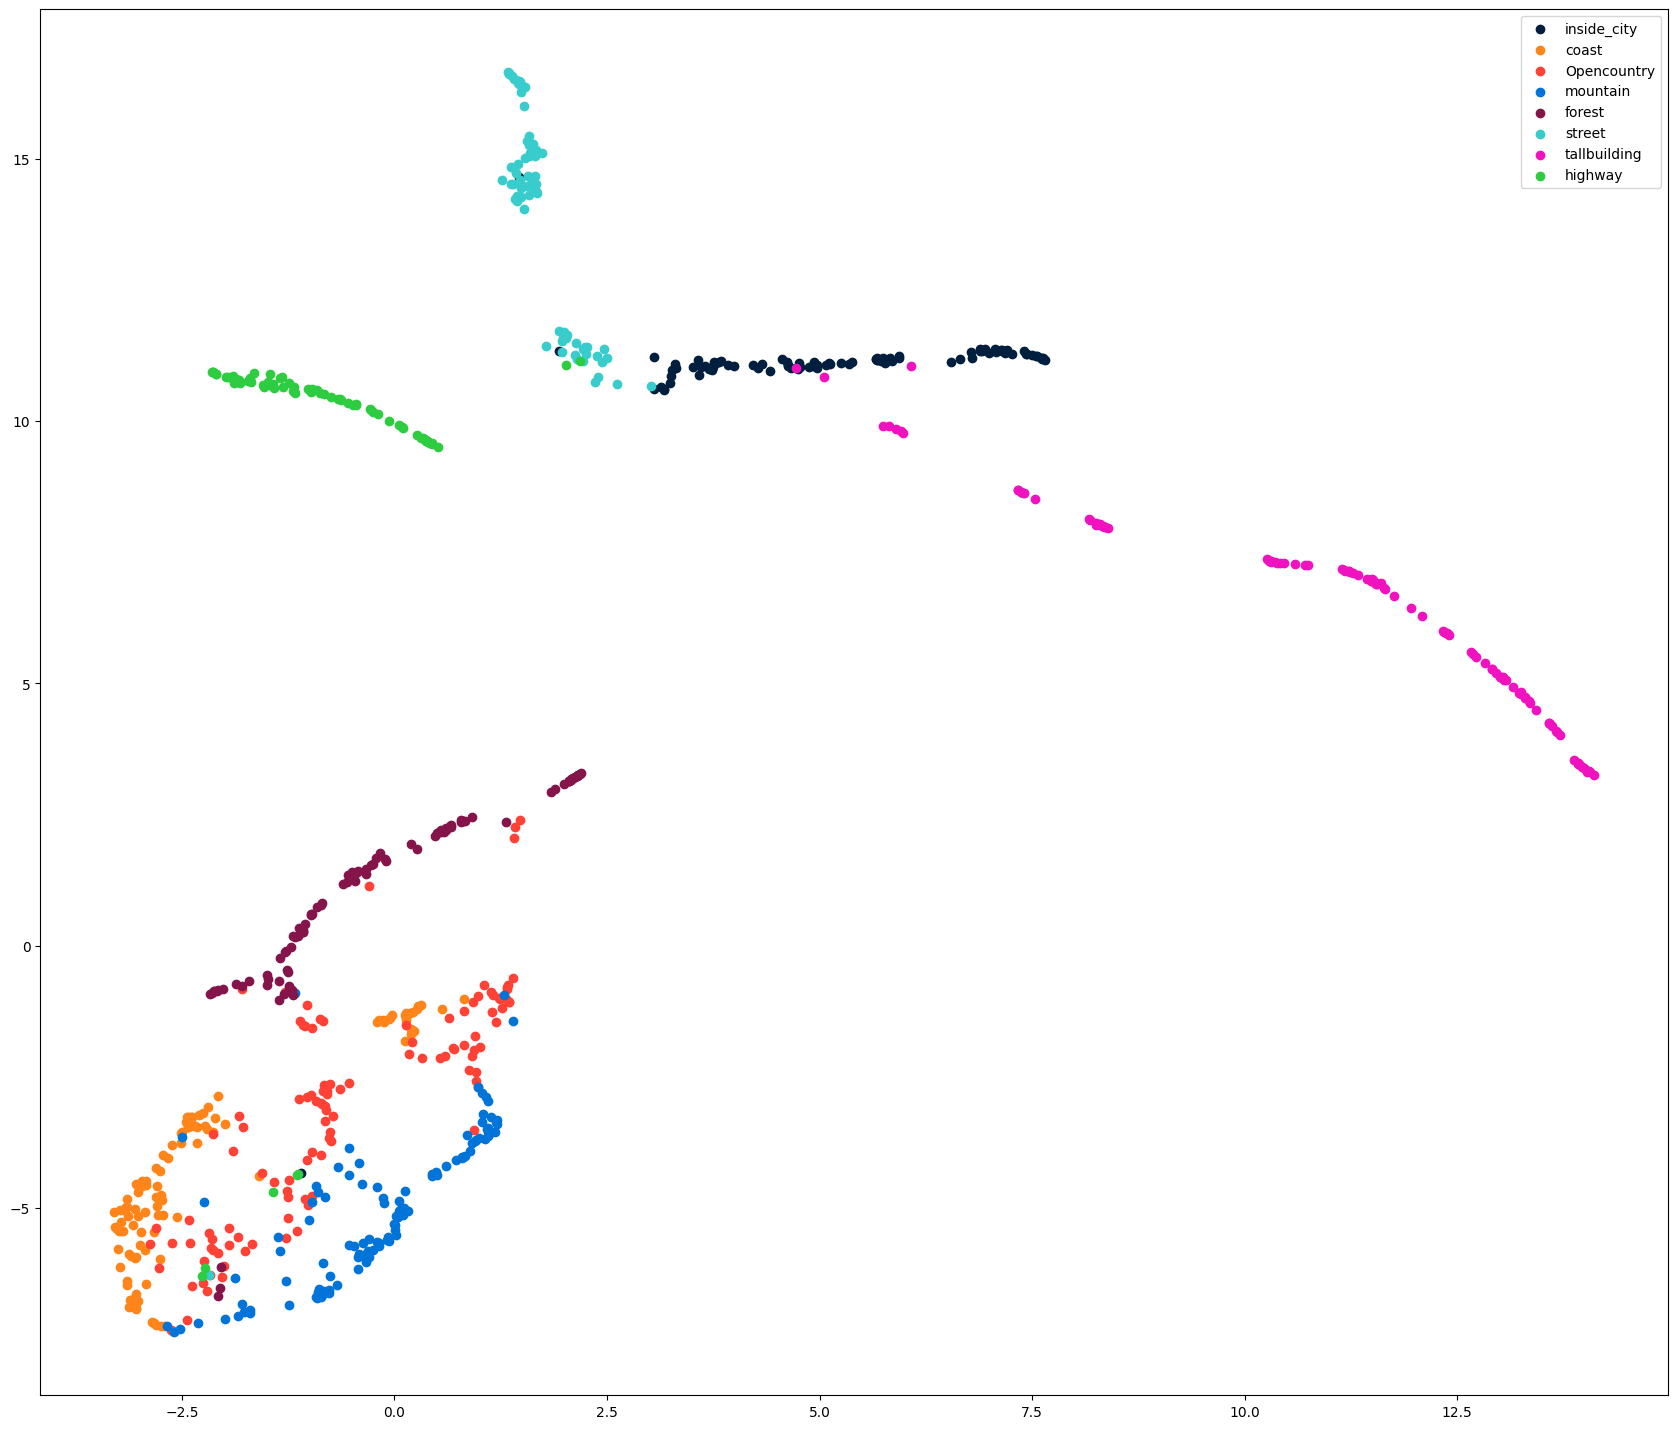

In [92]:
import numpy as np
from ast import literal_eval


colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)']


lab = list(class_mapping.keys())


plot_embedding_v1(projected_embeddings, np.array(labels), labels=lab, colors=colors)

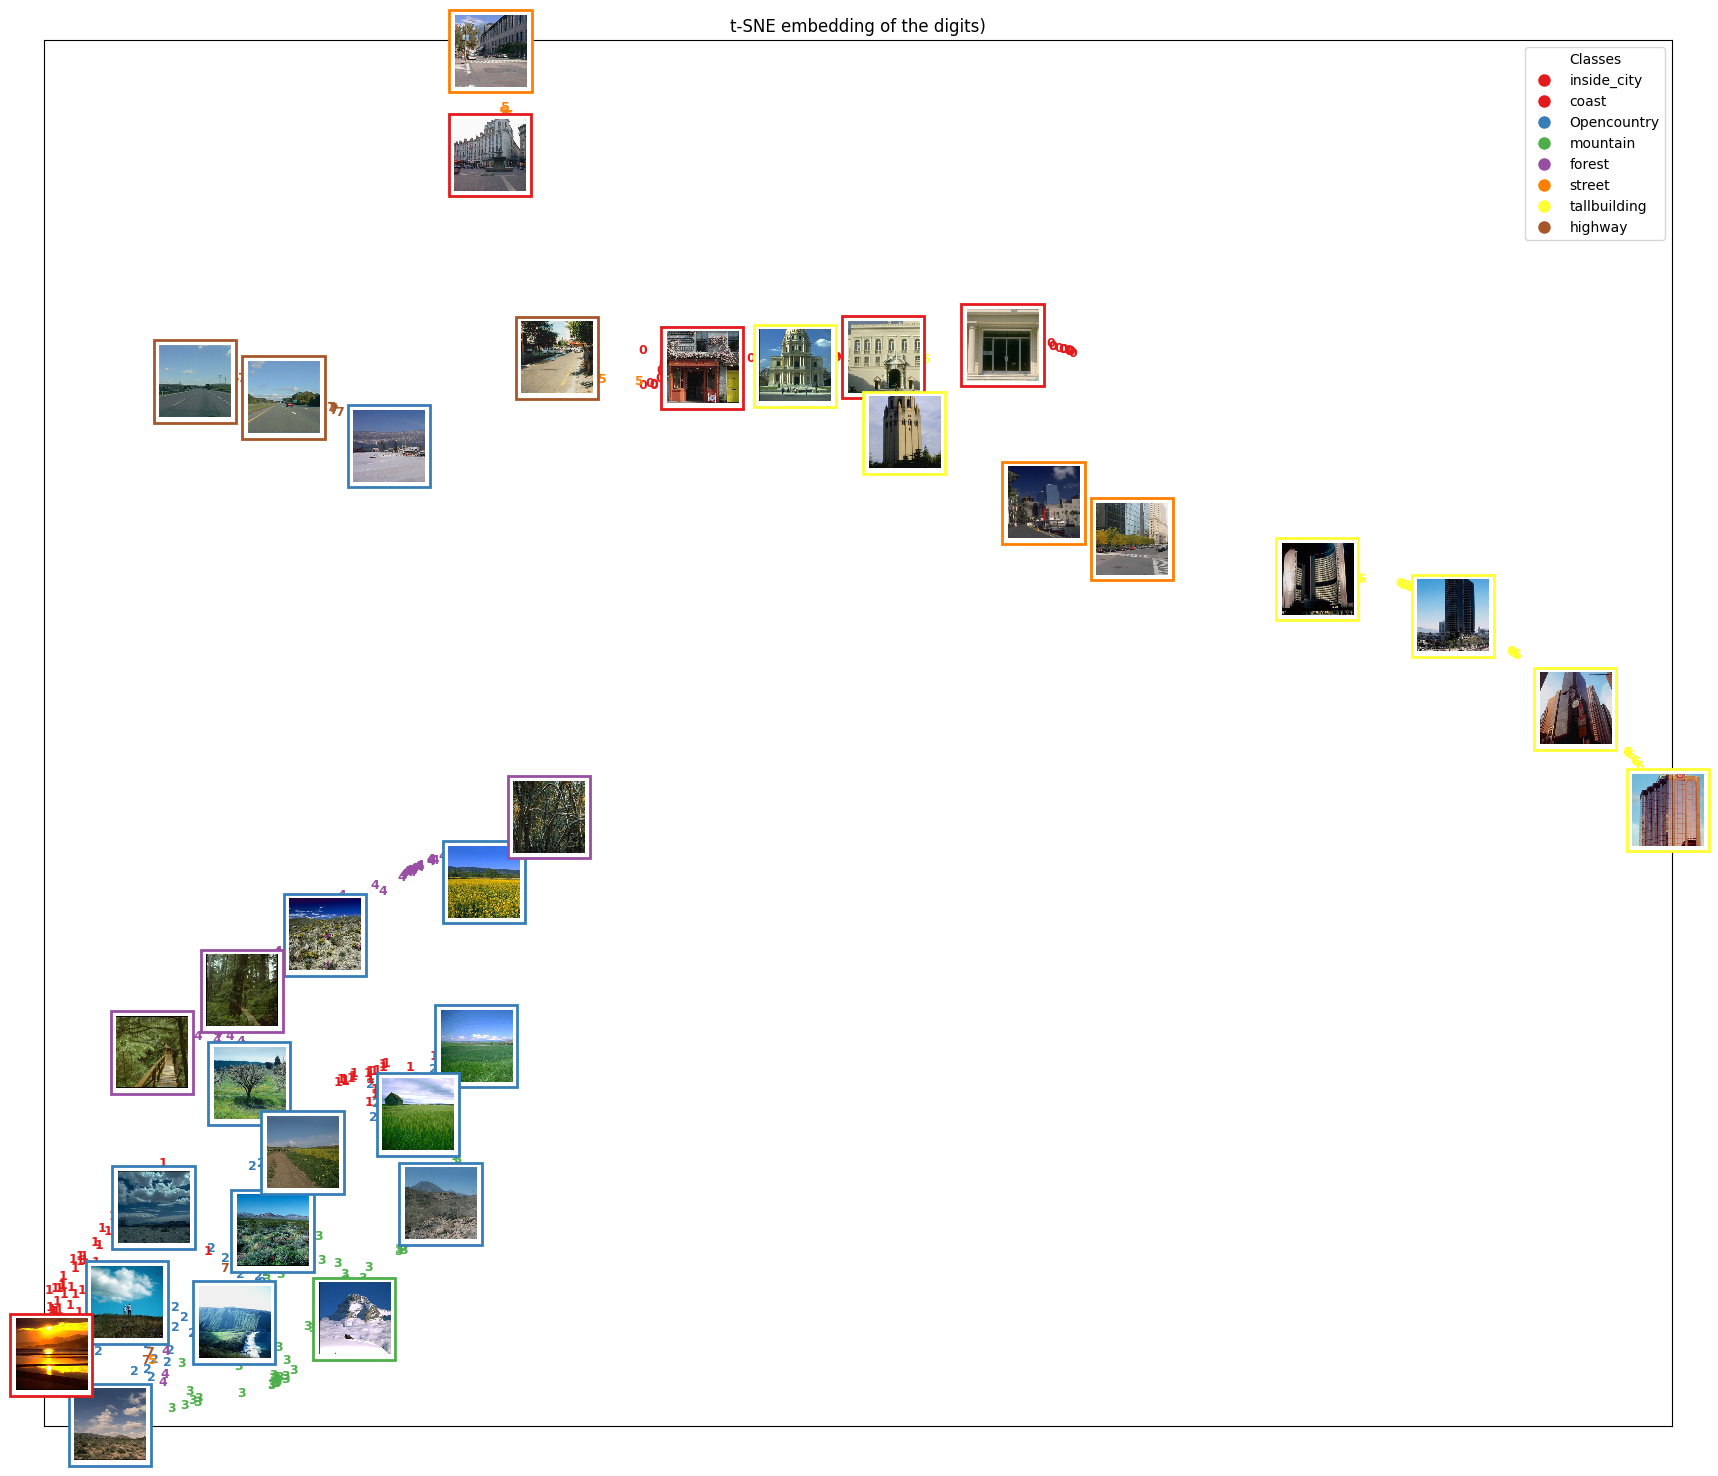

In [95]:
plot_embedding_v2(projected_embeddings, test_paths, np.array(labels),  "t-SNE embedding of the digits)")

### Ratifing the linearity

In [103]:

clf = SVC(probability=True)

train_labels  = [class_mapping[i.split("/")[4]] for i in train_paths]

clf.fit(train_embeddings, train_labels)
predictions = clf.predict(test_embeddings)
y_score = clf.predict_proba(test_embeddings)

In [104]:
predictions = clf.predict(test_embeddings)

In [105]:
test_embeddings.shape
np.array(labels).astype(np.int32).shape

(807,)

In [106]:
accuracy_score(predictions, np.array(labels).astype(np.int32))

0.7695167286245354

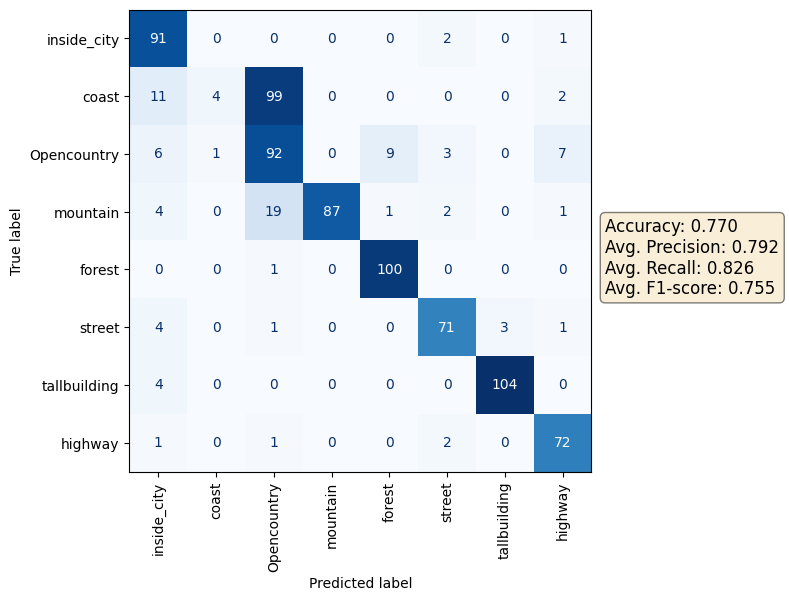

In [107]:
y_test = np.array(labels)

    
plot_confusion_matrix(predictions=predictions, y_test=y_test, display_labels=list(class_mapping.keys()))

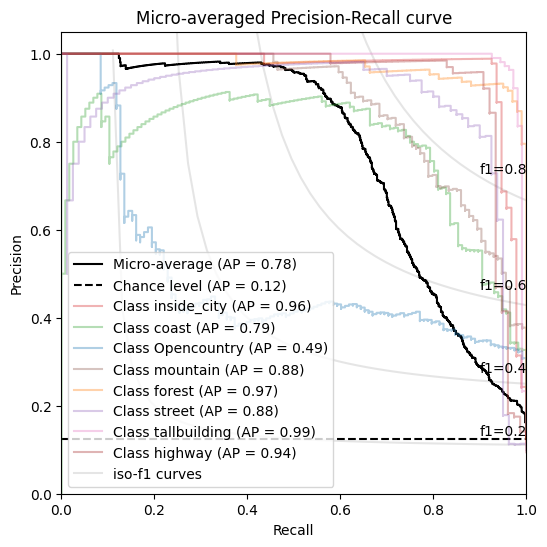

In [108]:
    
    
plot_pr_curve(score_pred=y_score, y_test=y_test, display_labels=list(class_mapping.keys()))

In [109]:
knn = KNeighborsClassifier(n_neighbors=1, p=2)
knn = knn.fit(train_embeddings, train_labels)
neighbors = knn.predict(test_embeddings)

In [111]:
accuracy_score(np.array(labels).astype(np.int32), neighbors)

0.8934324659231723

Number of samples: 807
Number of wrongly classified samples: 86


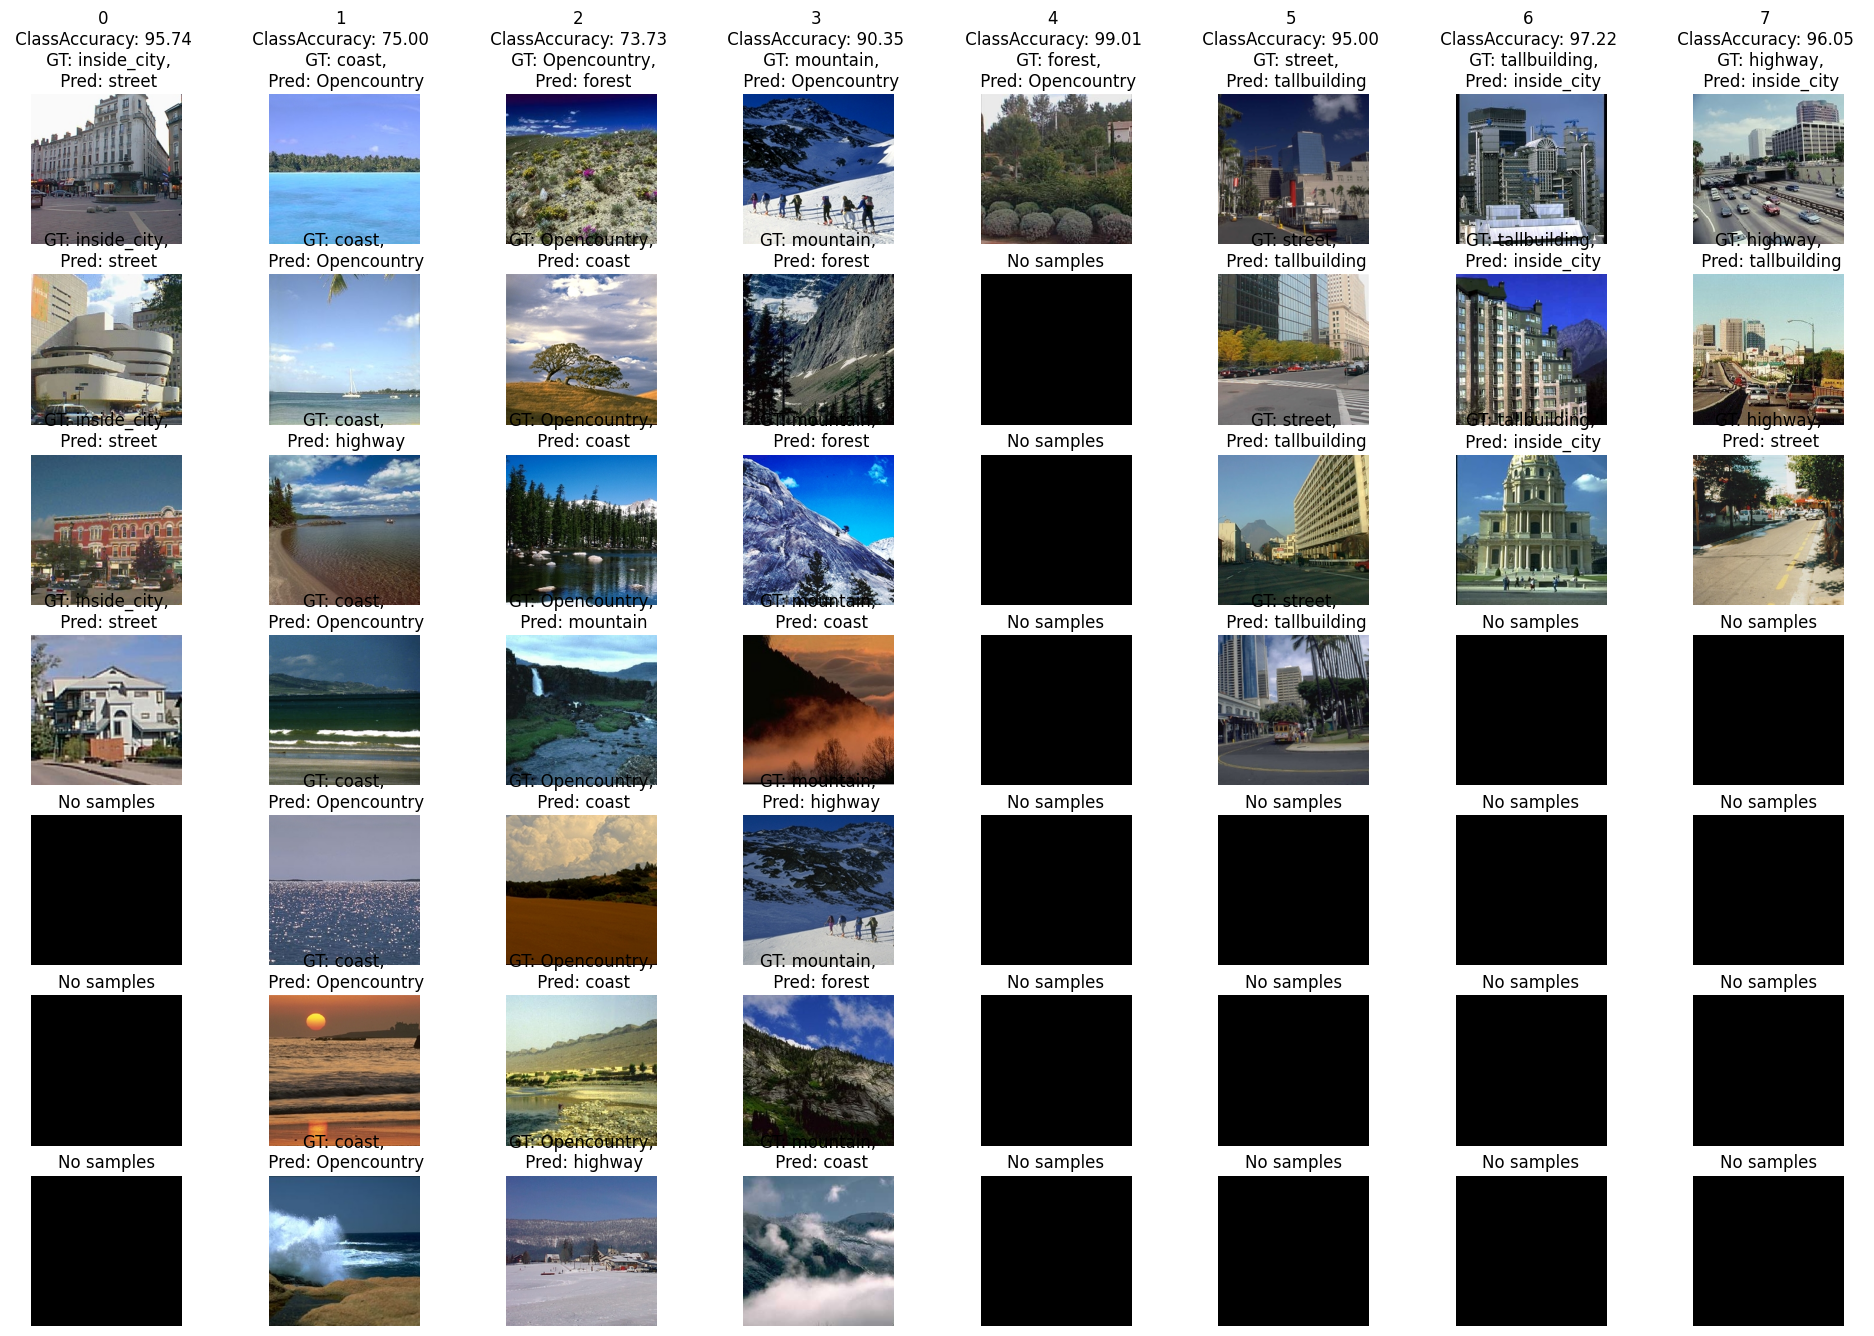

In [110]:
visualize_wrong_predictions(test_paths, labels, neighbors, class_mapping=inverse_class_mapping, samples_per_class=7)


In [115]:
missmatch_indexes = get_mismmatch_predictions(test_paths, labels, neighbors)

Number of samples: 807
Number of wrongly classified samples: 86


In [116]:
CIR = CIR_extractiction(train_embeddings=train_embeddings, test_embeddings=test_embeddings, missmatch_indexes=missmatch_indexes, K=10)

{0: {465: (5, [(1461, array([-7.02276897, -4.19175291,  6.1870265 , ..., -1.14652586,
       -6.30334234,  3.89392996])), (1481, array([-6.70430231, -4.01977444,  6.01379347, ..., -1.37711632,
       -6.22268867,  3.52413869])), (1472, array([-6.89881802, -4.08850479,  6.07487535, ..., -1.69854677,
       -6.54667377,  4.08094931])), (1488, array([-6.91876888, -3.7801168 ,  6.27113771, ..., -1.70872998,
       -6.26862478,  4.00554514])), (1492, array([-6.97011614, -3.56932926,  6.10404921, ..., -1.76007617,
       -6.41150665,  3.8353653 ])), (1595, array([-7.08283901, -3.77949691,  6.26542425, ..., -1.7186203 ,
       -6.3209033 ,  3.98442578])), (1572, array([-7.29339123, -3.77764916,  6.40524292, ..., -1.689762  ,
       -6.56928253,  4.0522356 ])), (1568, array([-7.07478189, -3.7942276 ,  6.30908871, ..., -1.65590215,
       -6.32366323,  3.93003845])), (1438, array([-7.19304848, -3.79221034,  6.4271369 , ..., -1.78900027,
       -6.52842808,  4.03476667])), (1512, array([-7.00768

In [118]:
mean_average_appearence_at_k(CIR, train_labels, 10)

{0: 3.25,
 1: 1.6551724137931034,
 2: 3.129032258064516,
 3: 2.909090909090909,
 4: 2.0,
 5: 0.25,
 6: 0.0,
 7: 1.0}

In [119]:
df_Kneighbours = pd.DataFrame()
rows = []
for i in range(1, 25):
    CIR =  CIR_extractiction(train_embeddings=train_embeddings, test_embeddings=test_embeddings, missmatch_indexes=missmatch_indexes, K=i)
    appearence = mean_average_appearence_at_k(CIR, train_labels, 10)
    appearence["neigh"] = i
    rows.append(appearence)

df_kneigh = pd.DataFrame.from_dict(rows, orient='columns')


In [125]:
df_kneigh

,0,1,2,3,4,5,6,7,neigh
0,0.50,0.310345,0.387097,0.454545,0.0,0.00,0.0,0.333333,1
1,0.75,0.827586,0.645161,0.818182,0.0,0.00,0.0,0.666667,2
2,1.00,1.103448,1.000000,1.181818,0.0,0.00,0.0,0.666667,3
3,1.25,1.241379,1.548387,1.545455,1.0,0.00,0.0,0.666667,4
4,1.50,1.344828,1.838710,1.818182,1.0,0.00,0.0,0.666667,5
5,2.00,1.448276,2.129032,2.090909,1.0,0.00,0.0,1.000000,6
6,2.50,1.517241,2.516129,2.272727,1.0,0.00,0.0,1.000000,7
7,2.75,1.586207,2.838710,2.636364,2.0,0.25,0.0,1.000000,8
8,3.25,1.655172,3.129032,2.909091,2.0,0.25,0.0,1.000000,9
9,3.25,1.655172,3.129032,2.909091,2.0,0.25,0.0,1.000000,10


inside_city
coast
Opencountry
mountain
forest
street
tallbuilding
highway


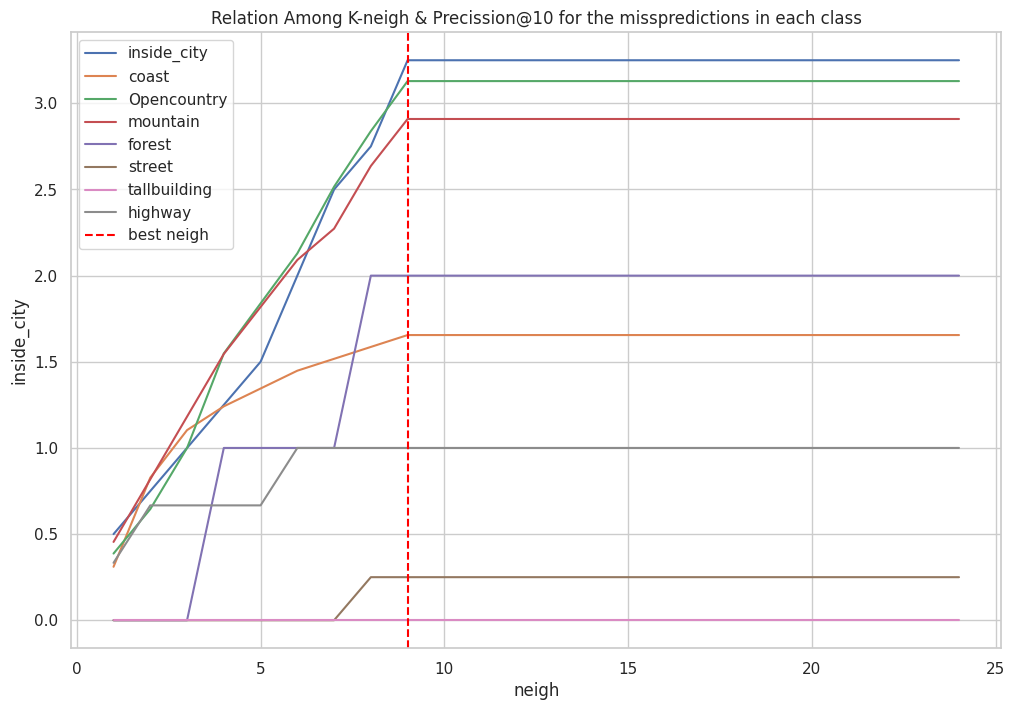

In [134]:
target_column = 'neigh'

# Obtén la lista de columnas (excluyendo la columna de nneighboors)
feature_columns = [inverse_class_mapping[col] for col in df_kneigh.columns if col != target_column]
df_kneigh.columns = feature_columns + ["neigh"]
# Configura el estilo de seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

for feature_column in feature_columns:
    print(feature_column)
    sns.lineplot(x=target_column, y=feature_column, data=df_kneigh, label=feature_column)

plt.axvline(x=9, color='red', linestyle='--', label='best neigh')
plt.title(f'Relation Among K-neigh & Precission@10 for the misspredictions in each class')
plt.legend()
plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

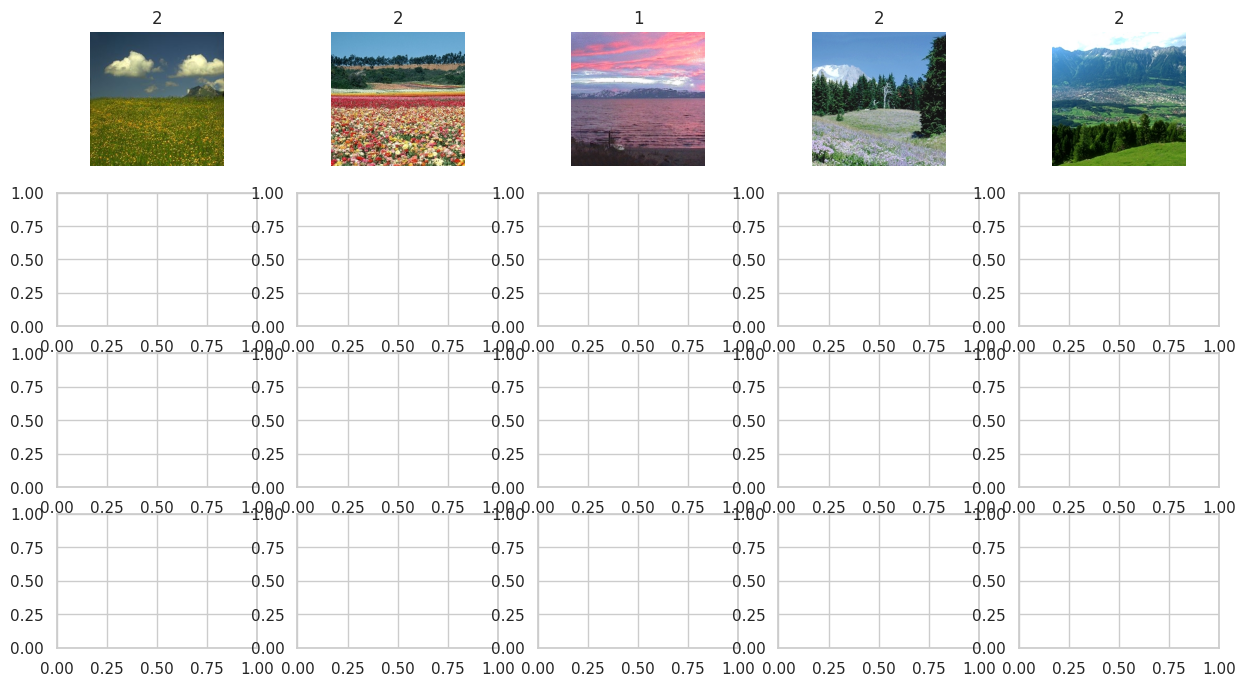

In [153]:
plot_CIR(result_dict=CIR,train_labels=train_labels,  train_image_paths=train_paths, test_image_paths=test_paths, clas="coast", sample=4, class_mapping=class_mapping)

## Visualizing the metric space given by the triplet

In [ ]:
model = custom_nn.Network()